# OULAD : Analyse Exploratoire des Profils d'Étudiants à Risque

Ce notebook effectue une analyse exploratoire des données (EDA) et des visualisations sur le jeu de données Open University Learning Analytics Dataset (OULAD) pour identifier le profil des étudiants à risque d'abandon scolaire (ceux qui abandonnent ou échouent). L'analyse inclut des statistiques descriptives, des histogrammes, une carte de chaleur des corrélations et des diagrammes de dispersion pour mettre en évidence les facteurs associés au risque d'abandon.

In [5]:
# Importer les bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurer le style des graphiques
plt.style.use('seaborn-v0_8') 
sns.set_palette('viridis')
%matplotlib inline

## Chargement et Prétraitement des Données

Charger les fichiers CSV de l'OULAD et les fusionner pour créer un jeu de données complet avec des informations démographiques, académiques et d'interactions avec l'environnement virtuel d'apprentissage (VLE).

In [9]:
def charger_donnees_oulad():
    # Charger les fichiers CSV
    student_info = pd.read_csv('../data/studentInfo.csv')
    student_assessment = pd.read_csv('../data/studentAssessment.csv')
    assessments = pd.read_csv('../data/assessments.csv')
    student_vle = pd.read_csv('../data/studentVle.csv')
    
    # Fusionner les évaluations des étudiants avec les détails des évaluations
    assessment_data = pd.merge(student_assessment, assessments, on=['id_assessment'], how='left')
    
    # Agréger les scores moyens par étudiant et module
    student_scores = assessment_data.groupby(['id_student', 'code_module', 'code_presentation'])['score'].mean().reset_index()
    
    # Agréger les interactions VLE (somme des clics par étudiant et module)
    vle_agg = student_vle.groupby(['id_student', 'code_module', 'code_presentation'])['sum_click'].sum().reset_index()
    vle_agg.columns = ['id_student', 'code_module', 'code_presentation', 'total_clicks']
    
    # Fusionner avec les informations des étudiants
    data = pd.merge(student_info, student_scores, on=['id_student', 'code_module', 'code_presentation'], how='left')
    data = pd.merge(data, vle_agg, on=['id_student', 'code_module', 'code_presentation'], how='left')
    
    # Gérer les valeurs manquantes
    data['score'] = data['score'].fillna(data['score'].mean())
    data['total_clicks'] = data['total_clicks'].fillna(0)
    
    return data

df = charger_donnees_oulad()
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,total_clicks
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,82.000000,934.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,66.400000,1435.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,72.768254,281.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,76.000000,2158.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,54.400000,1034.0


In [10]:
def pretraiter_donnees(df):
    # Encoder les variables catégoriques
    df['gender'] = df['gender'].map({'M': 0, 'F': 1})
    df['disability'] = df['disability'].map({'N': 0, 'Y': 1})
    education_mapping = {
        'No Formal quals': 0,
        'Lower Than A Level': 1,
        'A Level or Equivalent': 2,
        'HE Qualification': 3,
        'Post Graduate Qualification': 4
    }
    df['highest_education'] = df['highest_education'].map(education_mapping)
    
    # Encoder l'indice de privation multiple (IMD band)
    df['imd_band'] = df['imd_band'].replace('missing', np.nan)
    df['imd_band'] = df['imd_band'].str.replace('%', '').str.split('-').str[0].astype(float)
    df['imd_band'] = df['imd_band'].fillna(df['imd_band'].mean())
    
    # Créer une variable cible binaire : 1 pour à risque (abandon ou échec), 0 pour succès (réussite ou distinction)
    df['at_risk'] = df['final_result'].isin(['Withdrawn', 'Fail']).astype(int)
    
    return df

df = pretraiter_donnees(df)
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,total_clicks,at_risk
0,AAA,2013J,11391,0,East Anglian Region,3,90.0,55<=,0,240,0,Pass,82.000000,934.0,0
1,AAA,2013J,28400,1,Scotland,3,20.0,35-55,0,60,0,Pass,66.400000,1435.0,0
2,AAA,2013J,30268,1,North Western Region,2,30.0,35-55,0,60,1,Withdrawn,72.768254,281.0,1
3,AAA,2013J,31604,1,South East Region,2,50.0,35-55,0,60,0,Pass,76.000000,2158.0,0
4,AAA,2013J,32885,1,West Midlands Region,1,50.0,0-35,0,60,0,Pass,54.400000,1034.0,0


## Analyse Exploratoire des Données

Calculer les statistiques descriptives et visualiser les distributions pour identifier les tendances associées au risque d'abandon.

In [11]:
# Statistiques descriptives
print('Nombre total d\'étudiants :', len(df))
print('Taux d\'abandon :', f'{df["at_risk"].mean():.2%}')
df.describe()

Nombre total d'étudiants : 32593
Taux d'abandon : 52.80%


,id_student,gender,highest_education,imd_band,num_of_prev_attempts,studied_credits,disability,score,total_clicks,at_risk
count,3.259300e+04,32593.000000,32593.000000,32593.000000,32593.000000,32593.000000,32593.000000,32593.000000,32593.000000,32593.000000
mean,7.066877e+05,0.451569,1.739331,42.115495,0.163225,79.758691,0.097076,72.768254,1215.141257,0.527966
std,5.491673e+05,0.497657,0.749598,27.674397,0.479758,41.071900,0.296066,14.574559,1692.604449,0.499225
min,3.733000e+03,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000
25%,5.085730e+05,0.000000,1.000000,20.000000,0.000000,60.000000,0.000000,68.000000,142.000000,0.000000
50%,5.903100e+05,0.000000,2.000000,40.000000,0.000000,60.000000,0.000000,72.768254,602.000000,1.000000
75%,6.444530e+05,1.000000,2.000000,70.000000,0.000000,120.000000,0.000000,82.400000,1585.000000,1.000000
max,2.716795e+06,1.000000,4.000000,90.000000,6.000000,655.000000,1.000000,100.000000,24139.000000,1.000000


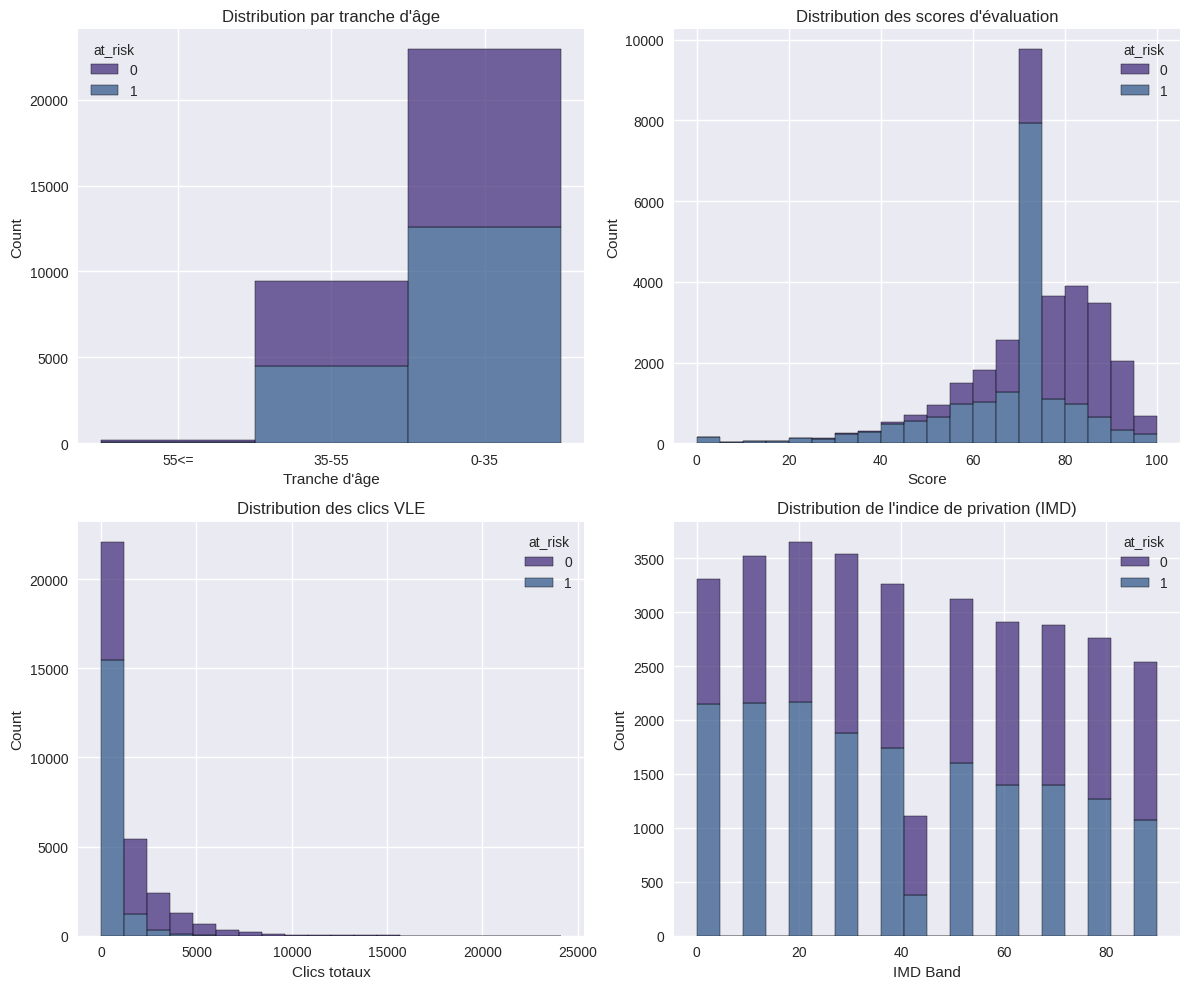

In [12]:
# Histogrammes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(data=df, x='age_band', hue='at_risk', multiple='stack', ax=axes[0, 0])
axes[0, 0].set_title('Distribution par tranche d\'âge')
axes[0, 0].set_xlabel('Tranche d\'âge')
sns.histplot(data=df, x='score', hue='at_risk', multiple='stack', bins=20, ax=axes[0, 1])
axes[0, 1].set_title('Distribution des scores d\'évaluation')
axes[0, 1].set_xlabel('Score')
sns.histplot(data=df, x='total_clicks', hue='at_risk', multiple='stack', bins=20, ax=axes[1, 0])
axes[1, 0].set_title('Distribution des clics VLE')
axes[1, 0].set_xlabel('Clics totaux')
sns.histplot(data=df, x='imd_band', hue='at_risk', multiple='stack', bins=20, ax=axes[1, 1])
axes[1, 1].set_title('Distribution de l\'indice de privation (IMD)')
axes[1, 1].set_xlabel('IMD Band')
plt.tight_layout()
plt.show()

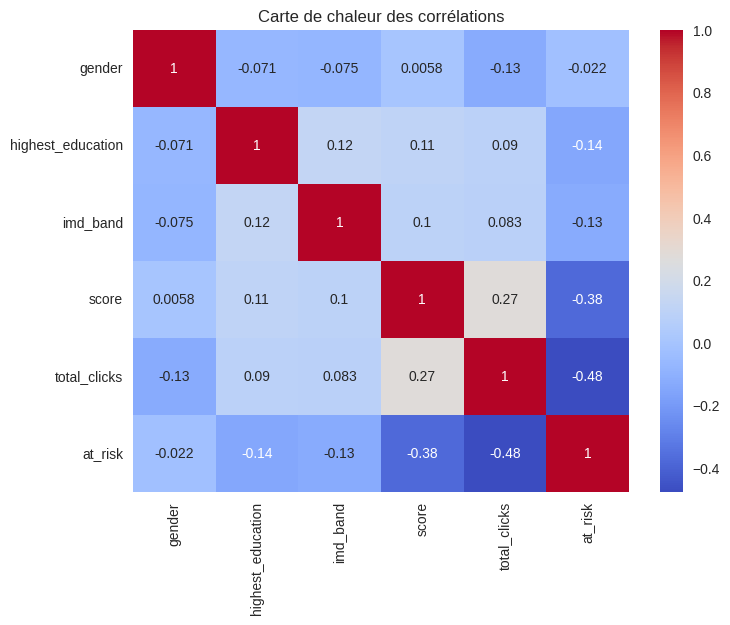

In [13]:
# Carte de chaleur des corrélations
corr_features = ['gender', 'highest_education', 'imd_band', 'score', 'total_clicks', 'at_risk']
corr = df[corr_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Carte de chaleur des corrélations')
plt.show()

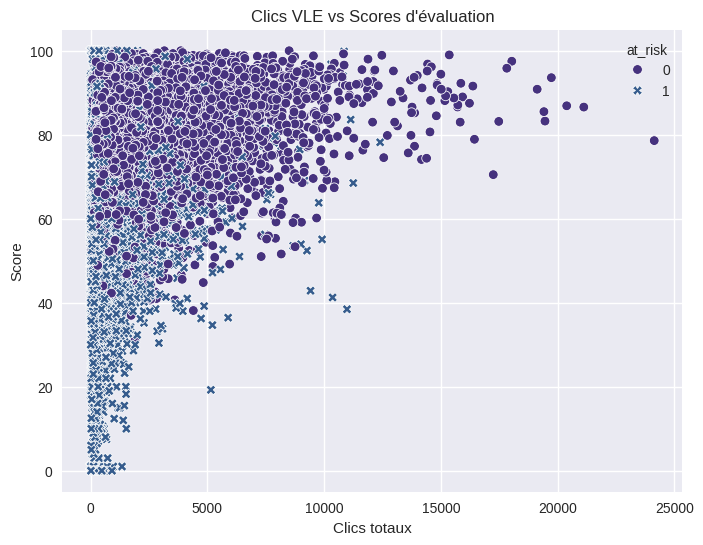

In [14]:
# Diagramme de dispersion : clics VLE vs scores d'évaluation
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='total_clicks', y='score', hue='at_risk', style='at_risk')
plt.title('Clics VLE vs Scores d\'évaluation')
plt.xlabel('Clics totaux')
plt.ylabel('Score')
plt.show()

## Profil des Étudiants à Risque

Résumer les caractéristiques des étudiants ayant abandonné ou échoué.

In [15]:
at_risk_df = df[df['at_risk'] == 1]
print('Nombre d\'étudiants à risque :', len(at_risk_df))
print('Tranche d\'âge la plus fréquente :', at_risk_df['age_band'].mode()[0])
print('Score moyen d\'évaluation :', at_risk_df['score'].mean())
print('Clics VLE moyens :', at_risk_df['total_clicks'].mean())
print('Indice de privation moyen (IMD) :', at_risk_df['imd_band'].mean())
print('Distribution par genre :', at_risk_df['gender'].value_counts(normalize=True).to_dict())
print('Distribution par niveau d\'éducation :', at_risk_df['highest_education'].value_counts(normalize=True).to_dict())

Nombre d'étudiants à risque : 17208
Tranche d'âge la plus fréquente : 0-35
Score moyen d'évaluation : 67.55559756008968
Clics VLE moyens : 452.4257322175732
Indice de privation moyen (IMD) : 38.752092249566
Distribution par genre : {0: 0.5589841933984193, 1: 0.4410158066015807}
Distribution par niveau d'éducation : {1: 0.4675732217573222, 2: 0.39150395165039514, 3: 0.12046722454672246, 0: 0.014179451417945141, 4: 0.006276150627615063}


In [ ]:
# Sauvegarder le jeu de données prétraité
df.to_csv('oulad_preprocessed.csv', index=False)
print('Jeu de données prétraité sauvegardé sous oulad_preprocessed.csv')

Jeu de données prétraité sauvegardé sous oulad_preprocessed.csv
